In [79]:
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_score, recall_score, roc_curve
from nibabel import processing

In [80]:
# subj_list = ['01010']
# subj_list = [line.rstrip('\n') for line in open('/Users/admin/controls_stroke_DL/reper_fold5_list.txt')]
# define subj_list
list_nonreper_test1 = ["03032","01020","01002","05002","08009","03045","11003","01042","30058A","30082A","08010","30049A","30073A"]
list_nonreper_test2 = ["09005","05011","05010","03002","01021","10002","30008A","30054","01010","30030A","01047","30032","03028"]
list_nonreper_test3 = ["09007","05006","11004","01017","03040","01007","05008","30007","01036","09006","09002","30043","10001"]
list_nonreper_test4 = ["03025","30037","09003","05007","05012","05003","30027A","05005","11002","10006","10007","30084A","02003"]
list_nonreper_test5 = ["01027","01038","01041","02005","01040","08007","10004","03018","09004","01004","01045"]

list_reper_test1 = ["30012","01028","30042","30116","03027","30006A","03017","30068","03043","03016","01003","03046","30099","30117","30046A","30102","03042","30028","03047","01029","01006"]
list_reper_test2 = ["08005","01048","30063","30101","05001","10003","03008","30069A","08008","30035A","03007","30041","30040","30096","30126","08003","30108","30097","03033","30120","01001"]
list_reper_test3 = ["03036","30122","30018A","30048A","30053","03039","30098","30055","03026","01015","03037","30127","30078A","30071A","03024","01043","03011","30057A","30024A","30115","30002A"]
list_reper_test4 = ["03013","03035","08001","03031","30056","02004","03041","01032","03019","30103","30023","30061","03009","03020","30047A","30026A","30109","05009","03048","10009","30090A"]
list_reper_test5 = ["30092","30022A","30034","30106","30080","03001","01049","12001","30113","01044","30075A","30059A","03003","30077A","30045A","30124","02006","30001A"]
subj_list_core = sorted(list_reper_test1)+sorted(list_reper_test2)+sorted(list_reper_test3)+sorted(list_reper_test4)+sorted(list_reper_test5)
subj_list_penumbra = sorted(list_nonreper_test1)+sorted(list_nonreper_test2)+sorted(list_nonreper_test3)+sorted(list_nonreper_test4)+sorted(list_nonreper_test5)
print(subj_list_core)
subj_path = '/Users/admin/deepstroke173/deepstroke173/'

['01003', '01006', '01028', '01029', '03016', '03017', '03027', '03042', '03043', '03046', '03047', '30006A', '30012', '30028', '30042', '30046A', '30068', '30099', '30102', '30116', '30117', '01001', '01048', '03007', '03008', '03033', '05001', '08003', '08005', '08008', '10003', '30035A', '30040', '30041', '30063', '30069A', '30096', '30097', '30101', '30108', '30120', '30126', '01015', '01043', '03011', '03024', '03026', '03036', '03037', '03039', '30002A', '30018A', '30024A', '30048A', '30053', '30055', '30057A', '30071A', '30078A', '30098', '30115', '30122', '30127', '01032', '02004', '03009', '03013', '03019', '03020', '03031', '03035', '03041', '03048', '05009', '08001', '10009', '30023', '30026A', '30047A', '30056', '30061', '30090A', '30103', '30109', '01044', '01049', '02006', '03001', '03003', '12001', '30001A', '30022A', '30034', '30045A', '30059A', '30075A', '30077A', '30080', '30092', '30106', '30113', '30124']


In [ ]:
def dice_score(y_true, y_pred, smooth=0.0000001,threshold_true=0.1,threshold_pred=0.5, model='>'):
    '''
    
    :param y_true: array for ground truth
    :param y_pred: array for output
    :param smooth: usually no need to change, prevent 0/0 .
    :param threshold_true: above which ground truth is considered 1, the rest is 0
    :param threshold_pred: above / below which output is considered 1, the rest is 0
    :param model: '>' above the threshold_pred; '<' below the threshold_pred but >0
    :return: a dice score.
    '''
    y_true_f = y_true.flatten()>=threshold_true
    if model == '<':
        y_pred_f = np.logical_and(y_pred.flatten()<=threshold_pred, y_pred.flatten()>0)
    else:
        y_pred_f = y_pred.flatten()>=threshold_pred
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def specificity(y_true, y_pred, smooth = 0.00001, threshold_true = 0.1, threshold_pred =0.5, model = '>'):
    y_neg_f = y_true.flatten() < threshold_true
    if model == '<':
        y_pred_pos_f = np.logical_and(y_pred.flatten() <= threshold_pred, y_pred.flatten()>0)
    else:
        y_pred_pos_f = y_pred.flatten() >= threshold_pred
    false_pos = np.sum(y_neg_f * y_pred_pos_f)
    return np.sum(y_neg_f) / (np.sum(y_neg_f) + false_pos + smooth)

def vol_diff(y_true, y_pred, threshold_true = 0.1, threshold_pred =0.5, model = '>'):
    y_true_f = y_true.flatten() >= threshold_true
    if model == '<':
        y_pred_f = np.logical_and(y_pred.flatten() <= threshold_pred, y_pred.flatten()>0)
    else:
        y_pred_f = y_pred.flatten() >= threshold_pred
    return np.sum(y_pred_f) - np.sum(y_true_f)

In [85]:
threshold_true =0.9

list_result = {'auc':[],'precision':[],'recall':[],'dice':[],'auc_all':[]}
for subject_name in subj_list_core:
    #load data
    ADC_path = subj_path + subject_name + '/ADC.nii'
    lesion_path = subj_path + subject_name +'/LESION.nii'
    # DWI_path = subj_path + subject_name + '/DWI.nii'
    ADC_load = nib.load(ADC_path)
    ADC_smooth = processing.smooth_image(ADC_load,3) # smooth out noise
    ADC = ADC_smooth.get_fdata()
    TMAX_path = subj_path + subject_name + '/PWITMAX.nii'
    TMAX_load = nib.load(TMAX_path)
    tmax_smooth = processing.smooth_image(TMAX_load,3)
    tmax = tmax_smooth.get_fdata()
    #import template mask
    brain_mask_data = nib.load('/Users/admin/controls_stroke_DL/001/T1.nii')
    brain_mask = brain_mask_data.get_fdata()
    
    lesion_load = nib.load(lesion_path)
    lesion = lesion_load.get_fdata()
    lesion[np.isnan(lesion)] = 0
    # DWI_load = nib.load(DWI_path)
    # DWI = DWI_load.get_fdata()
    # print(lesion[:,:,50])
    list_auc=[]
    list_precision=[]
    list_recall=[]
    list_dice = []
    list_specificity = []
    list_voldiff = []
    y_true_data = []
    y_pred_data = []
    if subject_name not in ['08005','08008','08009']:
        threshold_pred = 620
    else:
        threshold_pred = 310
        
    lesion_side = ''  
    for slice_num in range(91):
        if np.max(lesion[:,:,slice_num])> threshold_true:
            if np.sum(lesion[0:46,:,slice_num]) > np.sum(lesion[46:91,:,slice_num]): ## If stroke in Left side of the image and Right side of the brain
                lesion_side += 'L'
            elif np.sum(lesion[0:46,:,slice_num]) < np.sum(lesion[46:91,:,slice_num]): ## If stroke in Right side of the image and Left side of the brain
                lesion_side += 'R'
        else:
            continue
    if (lesion_side.count('L') > lesion_side.count('R') and (lesion_side.count('R') > 1)) or (lesion_side.count('L') < lesion_side.count('R') and (lesion_side.count('L') >1)):
        lesion_side = 'B'
        # print('bilateral stroke',lesion_side,'L:',lesion_side.count('L'),'R:',lesion_side.count('R'))
    for slice_num in range(91):  
        if np.max(lesion[:,:,slice_num])> threshold_true or np.sum(np.logical_and(ADC[:,:,slice_num] > 0 , ADC[:,:,slice_num] < threshold_pred))>0:
            # y_pred_raw = np.logical_and(ADC[:,:,slice_num] > 0 , ADC[:,:,slice_num] < threshold_pred)
            mask = brain_mask[:,:,slice_num] > 0
            mask = mask * 1.0
            adc_mask = (ADC[:,:,slice_num] >0) * 1.0
            adc_mask[adc_mask==0] = np.NaN
            # select out the hemisphere with stroke lesions
            if lesion_side == 'B':
                mask =mask
            elif lesion_side.count('L') > lesion_side.count('R'): ## If stroke in Left side of the image and Right side of the brain
                mask[46:91, :] = np.NaN

            elif lesion_side.count('L') < lesion_side.count('R'): ## If stroke in Right side of the image and Left side of the brain
                mask[0:46, :] = np.NaN
    # for slice_num in range(91):  
    #     if np.max(lesion[:,:,slice_num])>0:
    #         mask = (brain_mask[:,:,slice_num] > 0) * 1.0  ## T1 template mask
    #         #for adc map , adc need >0 and <620
    #         y_pred_raw = np.logical_and(ADC[:,:,slice_num] > 0 , ADC[:,:,slice_num] < threshold_pred)
    #         adc_mask = (ADC[:,:,slice_num] >0) * 1.0
    #         adc_mask[adc_mask==0] = np.NaN
    #         # select out the hemisphere with stroke lesions
    #         if np.sum(lesion[0:46,:,slice_num]) > np.sum(lesion[46:91,:,slice_num]): ## If stroke in Left side of the image and Right side of the brain
    #             mask[46:91,:]=np.NaN
    #         elif np.sum(lesion[0:46,:,slice_num]) < np.sum(lesion[46:91,:,slice_num]): ## If stroke in Right side of the image and Left side of the brain
    #             mask[0:46,:]=np.NaN
    #         elif np.sum(y_pred_raw[0:46,:]) > np.sum(y_pred_raw[46:91,:]): ## If prediction in Left side of the image and Right side of the brain
    #             mask[46:91,:]=np.NaN
    #         elif np.sum(y_pred_raw[0:46,:]) < np.sum(y_pred_raw[46:91,:]): ## If prediction in Right side of the image and Left side of the brain
    #             mask[0:46,:]=np.NaN
    #         else:
    #             if np.sum(lesion[0:46,:,slice_num]) == np.sum(lesion[46:91,:,slice_num]):
    #                 print('Left lesion size = Right lesion size',np.sum(lesion[0:46,:,slice_num]))
    #             elif np.sum(y_pred_raw[0:46,:]) == np.sum(y_pred_raw[46:91,:]):
    #                 print('Left pred size = Right pred size',np.sum(y_pred_raw[0:46,:]))
    #             else:
    #                 print('check code')
            mask[mask == 0] = np.NaN
            y_true_masked = lesion[:,:,slice_num] * mask * adc_mask
            y_true_data.append(y_true_masked)
            # brain_mask = DWI[:,:,slice_num] > 50  ## change the input image to adjust brain mask
            y_pred_masked = ADC[:,:,slice_num] * mask * adc_mask
            y_pred_data.append(y_pred_masked)
        else:
            continue
    y_true = np.array(y_true_data).flatten()
    y_true = y_true[~np.isnan(y_true)]
    y_pred = np.array(y_pred_data).flatten()
    y_pred = y_pred[~np.isnan(y_pred)]
    y_thresholded = np.logical_and(y_pred > 0 , y_pred<threshold_pred)
    fpr, tpr, thresholds = roc_curve(y_true>threshold_true,y_pred)
    list_auc.append(auc(fpr, tpr))
    list_precision.append(precision_score(y_true>threshold_true,y_thresholded))
    list_recall.append(recall_score(y_true>threshold_true, y_thresholded))                
    list_dice.append(dice_score(y_true,y_thresholded, threshold_true=threshold_true,threshold_pred=0.5))
    list_specificity.append(specificity(y_true, y_thresholded,threshold_true=threshold_true,threshold_pred=0.5))
    list_voldiff.append(vol_diff(y_true, y_thresholded,threshold_true=threshold_true,threshold_pred=0.5))
    print(subject_name,np.mean(list_dice),1-np.mean(list_auc),np.mean(list_precision),np.mean(list_recall),np.mean(list_specificity),np.mean(list_voldiff),np.sum(y_thresholded))        
    # list_result['auc'].append(np.mean(list_auc))
    # list_result['precision'].append(np.mean(list_precision))
    # list_result['recall'].append(np.mean(list_recall))        
    # list_result['dice'].append(np.mean(list_dice))  
    # list_result['specificity'].append(np.mean(list_specificity))
    # list_result['volume_difference'].append(np.mean(list_voldiff))
    # fpr_all, tpr_all, thresholds_all = roc_curve(lesion.flatten()>threshold_true,ADC.flatten())
    # list_result['auc_all'].append(auc(fpr, tpr))

01003 0.4404597337950138 0.7786870883817127 0.5212676451341498 0.3813431815073177 0.9496202580523354 -3925.0 10697


01006 0.13600130144564826 0.8357004095122869 0.08971882378192746 0.28091397849462363 0.9627662375583601 3171.0 4659


01028 0.47315436240816855 0.8509197986845563 0.4483306836248013 0.5008880994671403 0.9842371602372841 330.0 3145


01029 0.0851739187932471 0.8586482783309162 0.045158123553747986 0.7479674796747967 0.889947628674074 13400.0 14261


03016 0.14887039238647157 0.9480297276313202 0.08161668839634942 0.845945945945946 0.9691831162528713 3465.0 3835


03017 0.0375318066151792 0.6743568393394006 0.025652173913043478 0.06990521327014218 0.9626633788756809 2912.0 4600


03027 0.3078303791753665 0.9260319673765413 0.20170538077036165 0.6496212121212122 0.9525523845308057 4690.0 6802
03042 0.0036570499796459055 0.5304704607111692 0.011960132890365448 0.0021585321981052886 0.9857426387158075 -6834.0 1505


03043 0.3054026503536656 0.8168079197453889 0.2197769953051643 0.5003340013360054 0.9551439391216762 3822.0 6816


03046 0.06915232632139655 0.7776512454415582 0.043209876543209874 0.17304625199362042 0.9602416117694558 3768.0 5022
03047 0.16877864653393745 0.6960301015126235 0.5977084659452578 0.0982628714943491 0.993817559208235 -7985.0 1571


30006A 0.6350300285496536 0.9045369018519482 0.5887901655306719 0.6891516489778474 0.9385850101853642 2393.0 16432


30012 0.09797917942237235 0.6601051844292215 0.2513089005235602 0.060851926977687626 0.9937321936450815 -2989.0 955


30028 0.28869608952415 0.758527242613646 0.6337289539056031 0.18692501831800049 0.9875220971727233 -8660.0 3623


30042 0.29402920962041434 0.6410448251627328 0.37817679558011047 0.24051300070274068 0.9589596797579734 -4144.0 7240
30046A 0.1391379496582139 0.7874799354693648 0.0791543756145526 0.5744870651204282 0.9360401583683888 7015.0 8136


30068 0.13661560469649933 0.5340539498182126 0.08270486775159672 0.3923985618900873 0.7411277099826752 21872.0 27713


30099 0.36133032694221157 0.7323906872722412 0.46822498173849525 0.29417163836622306 0.9738834079844051 -3240.0 5476


30102 0.399999999996152 0.7159875058650451 0.7302423603793466 0.27543720190779014 0.99264149306857 -4701.0 2847


30116 0.04361873989954614 0.7485417418618576 0.05732484076433121 0.035202086049543675 0.9959937197953554 -296.0 471


30117 0.3543950045834051 0.7072886592919216 0.3742851872348275 0.3365121486027034 0.9391994836850275 -1217.0 10842
01001 0.32188024622181904 0.6813113975191858 0.5874782963946481 0.22166557478130178 0.9547395196097289 -16158.0 9791


01048 0.3975530605378882 0.7549438352495157 0.6667083698235956 0.28321641156462585 0.971957009066396 -10823.0 7993


03007 0.12409167132129426 0.7531312764825031 0.08922829581993569 0.2036697247706422 0.9808744091001963 1398.0 2488


03008 0.35676792014149583 0.7419237659485296 0.4229749030810039 0.30848214285714287 0.9736304721923045 -1819.0 4901


03033 0.40964532177656215 0.8092792145771912 0.7498531139835488 0.2817950982556856 0.983120397162966 -11308.0 6808


05001 0.6354447862369407 0.8183436257040473 0.7096186203028604 0.5753097646925088 0.9573670937206148 -3330.0 14264


08003 0.2109868740859141 0.6880262155077885 0.23233404710920771 0.19323241317898487 0.9752074687953659 -756.0 3736
08005 0.36132132131915123 0.7894758527489376 0.6106374340235485 0.25656772432616853 0.982152328573754 -6798.0 4926


08008 0.17453225355802104 0.7724745853205507 0.1591545709192768 0.19319938176197837 0.9716712421952924 692.0 3927


10003 0.42807096846617615 0.7892225071540254 0.48539210661199383 0.38285829795835863 0.9824421806512095 -1045.0 3902


30035A 0.3326944757591167 0.7568350384678894 0.2936318407960199 0.38374512353706114 0.9357881977517467 2360.0 10050


30040 0.1858269465723324 0.6112408037848032 0.18835847782031073 0.1833625602805787 0.9371057658773605 -242.0 8882


30041 0.36781609194771286 0.7928342738147385 0.4446287847366238 0.3136337039204213 0.9883792578877518 -1007.0 2411


30063 0.03587443946132868 0.641893090047197 0.08106219426974144 0.023034154090548053 0.987759129363404 -3605.0 1431


30069A 0.3490693282883985 0.8819441963479173 0.49276466108149275 0.2702589807852966 0.9942375578844883 -1081.0 1313


30096 0.37206982542713046 0.8986563258560435 0.2590277777777778 0.6601769911504425 0.9819623355156065 1750.0 2880


30097 0.17709147771350486 0.7585741726106705 0.4897297297297297 0.10808876163206872 0.9956064413110298 -3266.0 925


30101 0.5479497629497799 0.7894966002953672 0.8620779900549594 0.401609363569861 0.9949069330464747 -4381.0 3821


30108 0.14793291157809352 0.8167837848942731 0.08181448331977217 0.7710889570552147 0.820195984638289 21972.0 24580


30120 0.5317868154416988 0.8291513269365036 0.5463046757164404 0.5180205949656751 0.9719311341415638 -362.0 6630


30126 0.5936540429583596 0.917033445541194 0.6458797327394209 0.5492424242424242 0.9972719316955826 -158.0 898


01015 0.0 0.8799694339167874 0.0 0.0 0.9661359510834733 4026.0 4105


01043 0.1706940874030139 0.6316665845586551 0.3733133433283358 0.11064207953788047 0.9549685425154089 -15835.0 6670


03011 0.2068328716432672 0.8767374298649104 0.18451400329489293 0.23529411764705882 0.9910960812872821 262.0 1214


03024 0.4730668222921708 0.6806201238087386 0.8459611772072636 0.3283376539209332 0.9832152562649151 -15106.0 9582


03026 0.01265822784695676 0.8978071219739087 0.006404391582799634 0.5384615384615384 0.9903227530261158 1080.0 1093
03036 0.17938659058168 0.7600767948069147 0.1424929178470255 0.24205967276227142 0.9744023406615983 1452.0 3530


03037 0.3985749075475847 0.7634617543563842 0.6627174565086983 0.2849864568554108 0.977025701694007 -8838.0 6668
03039 0.4408238115374495 0.71649086692674 0.7293733224413583 0.31586395107899123 0.9767714404935421 -11218.0 8569


30002A 0.029388611912112606 0.7666477692466915 0.024242424242424242 0.037308461025982675 0.979742057162653 809.0 2310


30018A 0.4566345441039249 0.738619659663053 0.6669072536990256 0.3471726470035694 0.9829868022392735 -5104.0 5542


30024A 0.17294900221657136 0.6591385522638215 0.5572930709086007 0.10235713578290581 0.9833724885588775 -16485.0 3709


30048A 0.4522437576353043 0.8636792701361805 0.42802842505371014 0.4793633166759208 0.9682768101770598 648.0 6051


30053 0.0536912751663993 0.706459885704232 0.04351464435146443 0.07008086253369272 0.9806445056999098 906.0 2390


30055 0.41688336398675435 0.7228891071588637 0.633847637415622 0.31057456057456057 0.9595060094746013 -10794.0 10370


30057A 0.13423556777274587 0.6846506216209858 0.07926676989161381 0.4379139072847682 0.8488037334955583 16397.0 20021


30071A 0.33582995951077094 0.7295567322645212 0.8763866877971473 0.2077125328659071 0.9977368562615829 -6094.0 1893


30078A 0.4878341844324447 0.8119781283574348 0.48390941597139453 0.49182313749242884 0.9841940516901784 54.0 3356
30098 0.0009555661729422589 0.3197904074694319 0.0004863024801426487 0.02727272727272727 0.9499752552795353 6059.0 6169


30115 0.16566964599784875 0.7133184274440556 0.1130535011046009 0.30989994734070564 0.9246855781181438 6613.0 10411


30122 0.022030843180305553 0.47235337365974817 0.07262323943661972 0.012984968914771387 0.9802536010252519 -10435.0 2272
30127 0.05604629911495443 0.7085942444464266 0.03786008230452675 0.10785463071512309 0.9792425021770298 1577.0 2430


01032 0.1631765025791902 0.6544812992537521 0.14940239043824702 0.17974835230677053 0.9846386299794367 339.0 2008


02004 0.36486486486312875 0.7263718716409946 0.4650655021834061 0.30018791105543374 0.9595197443630996 -4528.0 8244


03009 0.4642676858695877 0.837830152152302 0.7034527972027972 0.3464643203099774 0.9868526860449689 -4715.0 4576


03013 0.49731314115792313 0.909802483581297 0.3775964391691395 0.7281831187410587 0.992856169664448 649.0 1348


03019 0.2965131753980167 0.9381133866744475 0.20425375870920426 0.5407766990291262 0.9816665680168916 1697.0 2727


03020 0.10872959545622811 0.8081754340004146 0.06666666666666667 0.2946153846153846 0.9528449563844125 4445.0 5745


03031 0.3709411117158147 0.8956531236723413 0.24676592628752747 0.7466765140324964 0.974075069644975 2743.0 4097


03035 0.21350277998072276 0.8190703088240276 0.14279643008924778 0.42290748898678415 0.9644205326367595 3117.0 4706


03041 0.19688476739029037 0.6219289061262958 0.3812143643092928 0.13271346984259647 0.933898250650877 -18719.0 9997


03048 0.3044136191657981 0.7811895891092778 0.26015734454143763 0.3668135541710986 0.9410274030632224 2698.0 9279
05009 0.2669450690609228 0.8432920679065161 0.2326427771556551 0.31311228334589297 0.9765063854481437 918.0 3572


08001 0.001407855835542618 0.739195446319017 0.01858736059479554 0.0007316359379572724 0.9976150683411522 -6565.0 269


10009 0.5860602480794653 0.7690684808514332 0.8964987576236729 0.43531863551606886 0.9662358332032134 -23450.0 22135


30023 0.030807922036126756 0.6164719781749795 0.03157216494845361 0.030079803560466543 0.9864622644869565 -77.0 1552


30026A 0.3538448831225419 0.7439924171509371 0.38643333934692403 0.3263254113345521 0.9685040098378892 -1021.0 5543


30047A 0.17669425184127277 0.760651719587196 0.1922141119221411 0.1634933774834437 0.9857569412614753 -361.0 2055


30056 0.49892267176205596 0.8728372008764534 0.4622892635314996 0.5418616744669786 0.9890254171166343 331.0 2254


30061 0.5517419354767518 0.8528881349251562 0.8971884179605539 0.39836035028880196 0.9976892677339084 -2984.0 2383


30090A 0.11231622077541385 0.6044294177693308 0.3585994613312813 0.06658569693505752 0.9841189694969782 -11398.0 2599
30103 0.16964285713528382 0.7166621627763892 0.30063291139240506 0.1181592039800995 0.996194182696775 -976.0 632


30109 0.3708077468027679 0.9325860603611335 0.2542098445595855 0.6849912739965096 0.979493526527568 1942.0 3088


01044 0.041717294450349995 0.8995588943830792 0.0217712957091524 0.4975845410628019 0.9598866285040792 4524.0 4731


01049 0.0 0.7515395377183739 0.0 0.0 0.9882245085990259 1233.0 1323


02006 0.2133873066342823 0.724088024560039 0.5736494364554994 0.13107184086670812 0.989761060202561 -8688.0 2573


03001 0.04391088038023025 0.6258186971980169 0.43844492440604754 0.02311283160651258 0.9974665288525845 -8320.0 463


03003 0.5935813131750556 0.8532576867502191 0.567780698460383 0.621838371375694 0.9788006040281798 463.0 5326


12001 0.3098247044403809 0.6729894213538963 0.8383894098179813 0.19002375296912113 0.9973265934599785 -6186.0 1813


30001A 0.23277909738292019 0.7105664363600381 0.30132450331125826 0.18963977374218519 0.9864825287842071 -1245.0 2114


30022A 0.364873222010438 0.8359441409480011 0.4783137413862992 0.29492626843289177 0.9881311383789245 -1534.0 2467


30034 0.17236328124579192 0.7332437875369678 0.3214936247723133 0.11774516344229487 0.9931586099587534 -1900.0 1098


30045A 0.17705242333884638 0.8546067759628291 0.12176870748299319 0.3242753623188406 0.9770637718656282 1836.0 2940


30059A 0.5217841726588675 0.8507175552647571 0.8724018475750578 0.3721980458165695 0.993345444591207 -6983.0 5196


30075A 0.41329791053052845 0.7457719908239457 0.8097917839054586 0.27745107490600596 0.9937178807146637 -6819.0 3554
30077A 0.0010090817356036145 0.6128636172371479 0.0034802784222737818 0.0005900865460267506 0.9919659557620683 -4222.0 862


30080 0.669955352959287 0.8796242425710453 0.8593512214657589 0.5489664347114204 0.9823545961471165 -7059.0 12485
30092 0.3794351279771428 0.678940043368941 0.6407810403935013 0.26951288320481476 0.9753094007688602 -9242.0 6709


30106 0.47661612130125114 0.8057016711489997 0.4491576413959085 0.5076504590275417 0.9842418712683751 383.0 3324


30113 0.5849305433418984 0.8075982982180536 0.8665016931492576 0.44147312541473127 0.9894443070327232 -7392.0 7678


30124 0.49355932202553293 0.9070330627487537 0.36795552185999497 0.7493566649511065 0.977611071734304 2014.0 3957


In [88]:
threshold_true=0.9
for subject_name in subj_list_core:
    #load data
    # ADC_path = subj_path + subject_name + '/ADC.nii'
    lesion_path = subj_path + subject_name +'/LESION.nii'
    DWI_path = subj_path + subject_name + '/DWI.nii'
    brain_mask_data = nib.load('/Users/admin/controls_stroke_DL/001/T1.nii')
    brain_mask = brain_mask_data.get_fdata()
    
    DWI_load = nib.load(DWI_path)
    dwi = DWI_load.get_fdata()
    mask_dwi = (brain_mask[:,:,45] > 0)*1.0
    mask_dwi[mask_dwi == 0] = np.NaN
    dwi_masked = dwi[:,:,45] * mask_dwi
    dwi_num = dwi_masked.flatten()
    dwi_mean = np.mean(dwi_num[~np.isnan(dwi_num)])
    
    lesion_load = nib.load(lesion_path)
    lesion = lesion_load.get_fdata()
    lesion[np.isnan(lesion)] = 0
    # DWI_load = nib.load(DWI_path)
    # DWI = DWI_load.get_fdata()
    # print(lesion[:,:,50])

    list_voldiff = []
    y_true_data = []

    lesion_side = ''  
    for slice_num in range(91):
        if np.max(lesion[:,:,slice_num])> threshold_true:
            if np.sum(lesion[0:46,:,slice_num]) > np.sum(lesion[46:91,:,slice_num]): ## If stroke in Left side of the image and Right side of the brain
                lesion_side += 'L'
            elif np.sum(lesion[0:46,:,slice_num]) < np.sum(lesion[46:91,:,slice_num]): ## If stroke in Right side of the image and Left side of the brain
                lesion_side += 'R'
        else:
            continue
    if (lesion_side.count('L') > lesion_side.count('R') and (lesion_side.count('R') > 1)) or (lesion_side.count('L') < lesion_side.count('R') and (lesion_side.count('L') >1)):
        lesion_side = 'B'
        # print('bilateral stroke',lesion_side,'L:',lesion_side.count('L'),'R:',lesion_side.count('R'))
    for slice_num in range(91):  
        if np.max(lesion[:,:,slice_num])> threshold_true:
            # y_pred_raw = np.logical_and(ADC[:,:,slice_num] > 0 , ADC[:,:,slice_num] < threshold_pred)
            mask = (brain_mask[:,:,slice_num] > 0) * 1.0 
            dwi_mask = dwi[:,:,slice_num] > (0.3 * dwi_mean)
            # select out the hemisphere with stroke lesions
            if lesion_side == 'B':
                mask =mask
            elif lesion_side.count('L') > lesion_side.count('R'): ## If stroke in Left side of the image and Right side of the brain
                mask[46:91, :] = np.NaN

            elif lesion_side.count('L') < lesion_side.count('R'): ## If stroke in Right side of the image and Left side of the brain
                mask[0:46, :] = np.NaN
            else:
                print('check code')
    # for slice_num in range(91):  
    #     if np.max(lesion[:,:,slice_num])>0:
    #         mask = (brain_mask[:,:,slice_num] > 0) * 1.0  ## T1 template mask
    #         dwi_mask = dwi[:,:,slice_num] > (0.3 * dwi_mean) # remove ventricles   
    #         if np.sum(lesion[0:46,:,slice_num]) > np.sum(lesion[46:91,:,slice_num]): ## If stroke in Left side of the image and Right side of the brain
    #             mask[46:91,:]=np.NaN
    #         elif np.sum(lesion[0:46,:,slice_num]) < np.sum(lesion[46:91,:,slice_num]): ## If stroke in Right side of the image and Left side of the brain
    #             mask[0:46,:]=np.NaN
    #         else:
    #             if np.sum(lesion[0:46,:,slice_num]) == np.sum(lesion[46:91,:,slice_num]):
    #                 print('Left lesion size = Right lesion size',np.sum(lesion[0:46,:,slice_num]))
    #             else:
    #                 print('check code')
            mask[mask == 0] = np.NaN
            y_true_masked = lesion[:,:,slice_num] * mask * dwi_mask
            y_true_data.append(y_true_masked)
        else:
            continue  
    y_true = np.array(y_true_data).flatten()
    y_true = y_true[~np.isnan(y_true)]
    print(np.sum(y_true>threshold_true))

14612
1485


2814
860


370
1685


2112
8308


2986
1240


9530
14031


3873
12274


11180
1093


8188
8552


7088
767


11918


25847
18762


1090
6660


18050
17572
4492


11706
3235


4947
7684


9094
3405


5026
2391


1092
4184
8140


2713
6991


1028
79


22432
952


23700
13


2072
15273


19276
1501


10512
20012


5401
1483


21155
3684
7918


3298
109


3749
11829


853


1669
12753


9288
699


1030
1300


1354
1589


28675
6306


2631
6834


44277
1605


6488
2401


1923
5366


13949
1608


1146
206


90
11202


8779
4843


7938
3359


3993
2993


1104
12157


10287
5027
19488


15798
2899


15015


1941


## Tmax predict penumbra

In [15]:
threshold_true =0.1
# threshold_pred = 60
list_result = {'auc':[],'precision':[],'recall':[],'dice':[],'auc_all':[]}
for subject_name in subj_list:
    #load data
    TMAX_path = subj_path + subject_name + '/PWITMAX.nii'
    lesion_path = subj_path + subject_name +'/LESION.nii'
    DWI_path = subj_path + subject_name + '/DWI.nii'
    MTT_path = subj_path +subject_name + '/PWIMTT.nii'
    TMAX_load = nib.load(TMAX_path)
    ## for tmax map, smooth out the image
    tmax_smooth = processing.smooth_image(TMAX_load,3)
    tmax = tmax_smooth.get_fdata()
    lesion_load = nib.load(lesion_path)
    lesion = lesion_load.get_fdata()
    lesion[np.isnan(lesion)] = 0
    DWI_load = nib.load(DWI_path)
    dwi = DWI_load.get_fdata()
    brain_mask_data = nib.load('/Users/admin/controls_stroke_DL/001/T1.nii')
    brain_mask = brain_mask_data.get_fdata()
    mask_fordwi = brain_mask[:,:,45] > 0
    mask_dwi = mask_fordwi * 1.0
    mask_dwi[mask_dwi == 0] = np.NaN
    dwi_masked = dwi[:,:,45] * mask_dwi
    dwi_num = dwi_masked.flatten()
    dwi_mean = np.mean(dwi_num[~np.isnan(dwi_num)])
    #load pwi mask
    mtt_load = nib.load(MTT_path)
    mtt = mtt_load.get_fdata()
    
    # print(lesion[:,:,50])
    list_auc=[]
    list_precision=[]
    list_recall=[]
    list_dice = []
    list_specificity = []
    list_voldiff = []
    y_true_data = []
    y_pred_data = []
    if subject_name not in ['30073A','30082A','30084A']:
        for slice_num in range(91):  
            if np.max(lesion[:,:,slice_num])>0 or np.max(tmax[:,:,slice_num])> 60:
                
                mask = brain_mask[:,:,slice_num] > 0
                mask = mask * 1.0
                mask[mask == 0] = np.NaN
                PWImask = mtt[:,:,slice_num] > 0
                PWImask = PWImask * 1.0
                PWImask[PWImask == 0] = np.NaN
                dwi_mask = dwi[:,:,slice_num] > (0.3 * dwi_mean)
                y_true_masked = (lesion[:,:,slice_num] * mask) * PWImask* dwi_mask 
                y_true_data.append(y_true_masked)
                # brain_mask = DWI[:,:,slice_num] > 50  ## change the input image to adjust brain mask
                y_pred_masked = (tmax[:,:,slice_num] * mask) * PWImask * dwi_mask
                y_pred_data.append(y_pred_masked)
            else:
                continue
    else:
        for slice_num in range(91):  
            if np.max(lesion[:,:,slice_num])>0 or np.max(tmax[:,:,slice_num])> 6:
                mask = brain_mask[:,:,slice_num] > 0
                mask = mask * 1.0
                mask[mask == 0] = np.NaN
                PWImask = mtt[:,:,slice_num] > 0
                PWImask = PWImask * 1.0
                PWImask[PWImask == 0] = np.NaN
                dwi_mask = dwi[:,:,slice_num] > (0.3 * dwi_mean)
                y_true_masked = (lesion[:,:,slice_num] * mask) * PWImask * dwi_mask
                y_true_data.append(y_true_masked)
                # brain_mask = DWI[:,:,slice_num] > 50  ## change the input image to adjust brain mask
                y_pred_masked = (tmax[:,:,slice_num] * mask) * PWImask* dwi_mask 
                y_pred_data.append(y_pred_masked)
            else:
                continue
    y_true = np.array(y_true_data).flatten()
    y_true = y_true[~np.isnan(y_true)]
    y_pred = np.array(y_pred_data).flatten()
    y_pred = y_pred[~np.isnan(y_pred)]
    #for adc map , adc need >0 and <620
    if subject_name in ['30073A','30082A','30084A']:
        # print(subject_name)
        y_thresholded = y_pred > 6
        threshold_pred = 6
    else:
        y_thresholded = y_pred > 60
        threshold_pred = 60
    fpr, tpr, thresholds = roc_curve(y_true>threshold_true,y_pred)
    list_auc.append(auc(fpr, tpr))
    list_precision.append(precision_score(y_true>threshold_true,y_thresholded))
    list_recall.append(recall_score(y_true>threshold_true, y_thresholded))                
    list_dice.append(dice_score(y_true,y_pred, threshold_true=threshold_true,threshold_pred=threshold_pred))
    list_specificity.append(specificity(y_true, y_pred,threshold_true=threshold_true,threshold_pred=threshold_pred))
    list_voldiff.append(vol_diff(y_true, y_pred,threshold_true=threshold_true,threshold_pred=threshold_pred))

    # print(np.sum(y_true>=0.9))
    print(subject_name,np.mean(list_dice),np.mean(list_auc),np.mean(list_precision),np.mean(list_recall),np.mean(list_specificity),np.mean(list_voldiff)) 
    # list_result['auc'].append(np.mean(list_auc))
    # list_result['precision'].append(np.mean(list_precision))
    # list_result['recall'].append(np.mean(list_recall))        
    # list_result['dice'].append(np.mean(list_dice))   
    # fpr_all, tpr_all, thresholds_all = roc_curve(lesion.flatten()>threshold_true,ADC.flatten())
    # list_result['auc_all'].append(auc(fpr, tpr))

01004 0.4190044126239717 0.8058157429293347 0.3096223351317375 0.647887323943662 0.8410832383304647 19935.0
01027 0.4445310217189916 0.8997378949952595 0.32040436659763416 0.7256538675570395 0.8931382396928359 15910.0


01038 0.6151554212532857 0.847373691121995 0.5929645170489265 0.6390718299964875 0.8820365997118043 3542.0
01040 0.3577699104850506 0.7380700533356399 0.2774491640811589 0.5035446627506583 0.8164451450012223 20116.0


01041 0.23501384711557874 0.6417654282957497 0.16670187148831905 0.3981836528758829 0.7741545824135889 27522.0
01045 0.6417262717985457 0.8623125464837527 0.5769508670520231 0.722886112619953 0.8741599919134159 8382.0


02005 0.12879928902181692 0.6761961835437181 0.07100713784709328 0.6920679601890017 0.7061466330158879 87001.0
03018 0.4975838531129868 0.7987794982084038 0.3584755964105931 0.8131186198765087 0.7644559402945955 40875.0


08007 0.02237889470083066 0.5544783453153583 0.012341343500727436 0.11988304093567251 0.8860897186880623 17881.0
09004 0.05421415457086948 0.871477876743326 0.027973402924248384 0.8752796420581656 0.7746491129603531 54158.0


10004 0.2678626031998067 0.8460705737760236 0.16785360712802988 0.6627159248518472 0.8816048344557056 23382.0


In [83]:
threshold_true =0.9
# threshold_pred = 60
list_result = {'auc':[],'precision':[],'recall':[],'dice':[],'auc_all':[]}
for subject_name in subj_list_penumbra:
# for subject_name in ['01007']:
    #load data
    TMAX_path = subj_path + subject_name + '/PWITMAX.nii'
    lesion_path = subj_path + subject_name +'/LESION.nii'
    DWI_path = subj_path + subject_name + '/DWI.nii'
    ADC_path = subj_path +subject_name + '/ADC.nii'
    TMAX_load = nib.load(TMAX_path)
    ## for tmax map, smooth out the image
    tmax_smooth = processing.smooth_image(TMAX_load,3)
    tmax = tmax_smooth.get_fdata()
    lesion_load = nib.load(lesion_path)
    lesion = lesion_load.get_fdata()
    lesion[np.isnan(lesion)] = 0
    DWI_load = nib.load(DWI_path)
    dwi = DWI_load.get_fdata()
    brain_mask_data = nib.load('/Users/admin/controls_stroke_DL/001/T1.nii')
    brain_mask = brain_mask_data.get_fdata()
    # calcualte dwi mean to remove ventricles.
    mask_fordwi = brain_mask[:,:,45] > 0
    mask_dwi = mask_fordwi * 1.0
    mask_dwi[mask_dwi == 0] = np.NaN
    dwi_masked = dwi[:,:,45] * mask_dwi
    dwi_num = dwi_masked.flatten()
    dwi_mean = np.mean(dwi_num[~np.isnan(dwi_num)])
    
    # print(lesion[:,:,50])
    list_auc=[]
    list_precision=[]
    list_recall=[]
    list_dice = []
    list_specificity = []
    list_voldiff = []
    y_true_data = []
    y_pred_data = []
    
    if subject_name in ['30073A','30082A','30084A']:
        # print(subject_name)
        threshold_pred = 6
    else:
        threshold_pred = 60
        
    if subject_name in ['08005','08008','08009']:
        adc_threshold = 310
    else:
        adc_threshold = 620
        
    lesion_side = ''  
    for slice_num in range(91):
        if np.max(lesion[:,:,slice_num])> threshold_true:
            if np.sum(lesion[0:46,:,slice_num]) > np.sum(lesion[46:91,:,slice_num]): ## If stroke in Left side of the image and Right side of the brain
                lesion_side += 'L'
            elif np.sum(lesion[0:46,:,slice_num]) < np.sum(lesion[46:91,:,slice_num]): ## If stroke in Right side of the image and Left side of the brain
                lesion_side += 'R'
        else:
            continue
    if (lesion_side.count('L') > lesion_side.count('R') and (lesion_side.count('R') > 1)) or (lesion_side.count('L') < lesion_side.count('R') and (lesion_side.count('L') >1)):
        lesion_side = 'B'
        # print('bilateral stroke',lesion_side,'L:',lesion_side.count('L'),'R:',lesion_side.count('R'))
    for slice_num in range(91):  
        if np.max(lesion[:,:,slice_num])> threshold_true or np.max(tmax[:,:,slice_num])>threshold_pred:
            y_pred_raw = tmax[:,:,slice_num]
            mask = brain_mask[:,:,slice_num] > 0
            mask = mask * 1.0
            # select out the hemisphere with stroke lesions
            if lesion_side == 'B':
                mask =mask
            elif lesion_side.count('L') > lesion_side.count('R'): ## If stroke in Left side of the image and Right side of the brain
                mask[46:91, :] = np.NaN

            elif lesion_side.count('L') < lesion_side.count('R'): ## If stroke in Right side of the image and Left side of the brain
                mask[0:46, :] = np.NaN
            # 
            # elif np.sum(y_pred_raw[0:46,:]) > np.sum(y_pred_raw[46:91,:]): ## If prediction in Left side of the image and Right side of the brain
            #     mask[46:91,:]=np.NaN
            # elif np.sum(y_pred_raw[0:46,:]) < np.sum(y_pred_raw[46:91,:]): ## If prediction in Right side of the image and Left side of the brain
            #     mask[0:46,:]=np.NaN
            else:
                print('lesion side cannot decide, check data and code') 
            #     # elif np.sum(y_pred_raw[0:46,:]) == np.sum(y_pred_raw[46:91,:]):
            #     #     print('Left pred size = Right pred size',np.sum(y_pred_raw[0:46,:]))
            #     else:
            #         print('check data and code')
            mask[mask == 0] = np.NaN
            dwi_mask = dwi[:,:,slice_num] > (0.3 * dwi_mean) # remove ventricles            
            y_true_masked = (lesion[:,:,slice_num] * mask) * dwi_mask 
            y_true_data.append(y_true_masked)
            y_pred_masked = (y_pred_raw * mask) * dwi_mask
            y_pred_data.append(y_pred_masked)
        else:
            continue
    y_true = np.array(y_true_data).flatten()
    y_true = y_true[~np.isnan(y_true)]
    y_pred = np.array(y_pred_data).flatten()
    y_pred = y_pred[~np.isnan(y_pred)]
    
    fpr, tpr, thresholds = roc_curve(y_true>threshold_true,y_pred)
    list_auc.append(auc(fpr, tpr))
    list_precision.append(precision_score(y_true>threshold_true,y_pred>threshold_pred))
    list_recall.append(recall_score(y_true>threshold_true, y_pred>threshold_pred))                
    list_dice.append(dice_score(y_true,y_pred, threshold_true=threshold_true,threshold_pred=threshold_pred))
    list_specificity.append(specificity(y_true, y_pred,threshold_true=threshold_true,threshold_pred=threshold_pred))
    list_voldiff.append(vol_diff(y_true, y_pred,threshold_true=threshold_true,threshold_pred=threshold_pred))

    # print(np.sum(y_true>=0.9))
    print(subject_name,np.mean(list_dice),np.mean(list_auc),np.mean(list_precision),np.mean(list_recall),np.mean(list_specificity),np.mean(list_voldiff),np.sum(y_pred > threshold_pred)) 
    # list_result['auc'].append(np.mean(list_auc))
    # list_result['precision'].append(np.mean(list_precision))
    # list_result['recall'].append(np.mean(list_recall))        
    # list_result['dice'].append(np.mean(list_dice))   
    # fpr_all, tpr_all, thresholds_all = roc_curve(lesion.flatten()>threshold_true,ADC.flatten())
    # list_result['auc_all'].append(auc(fpr, tpr))

01002 0.504876219053767 0.811006877812292 0.3931948822547747 0.7115373860522343 0.8321886177070825 14892.0 32358
01020 0.46873256580496847 0.9035070989657623 0.31950494364931203 0.8795203654358584 0.8340415485604645 18418.0 28926


01042 0.18897381688017897 0.5276390872555377 0.15030008278145696 0.2544451256897609 0.8480674227202187 7911.0 19328
03032 0.5440428210248865 0.6861803595245672 0.43034055727554177 0.7394042210592904 0.7039742585699649 24977.0 59755


03045 0.2848952848947293 0.9208078325429127 0.16682652781583995 0.9747798238590872 0.7393289414867797 36294.0 43788
05002 0.1889217626424184 0.4680078754920853 0.11939670117390658 0.452293836194765 0.7386417928555101 29719.0 40378


08009 0.03398285268848039 0.9354983421324792 0.017417705337168424 0.6942675159235668 0.9427526043940795 6101.0 6258


08010 0.6959569556651028 0.7186456371084327 0.7175758212141895 0.6756026428959813 0.7533622691109301 -3550.0 57141
11003 0.44773544212474664 0.9048693804911282 0.3401607752450171 0.6665947345705654 0.9453127079221746 4642.0 9081


/Users/admin/anaconda3/envs/keras36/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in greater


30049A 0.6015899877030381 0.8681901547749951 0.88749595890657 0.4550092081031308 0.9464404807109734 -26461.0 27839
30058A 0.45851875397269215 0.7513433561909046 0.8233447488584474 0.31773127753303965 0.9384926219401996 -33456.0 21024


30073A 0.6806878256375734 0.885402691645742 0.8358173978252719 0.5741283281285213 0.9609519561965274 -9725.0 21336
30082A 0.4318023986928587 0.8159876562104218 0.7667133240018663 0.3005277458459609 0.9525095318861165 -23273.0 15003


01010 0.2641466930972604 0.8996053252629259 0.15351382488479262 0.9456451612903226 0.742219706031893 31992.0 38192
01021 0.3066678912550208 0.8530067861898523 0.19338584501332098 0.7403547671840355 0.8633562919817747 12756.0 17266


01047 0.23294151792125106 0.6660406870588723 0.17403937895741176 0.3521102044397649 0.8393708091899489 11661.0 23058
03002 0.31561866125689514 0.7330856293786334 0.6193719593100399 0.21176470588235294 0.9483582160063897 -21760.0 11305


03028 0.11393394104388793 0.8431545532815791 0.06046137608684726 0.985661614092585 0.7375691382810478 37353.0 39794
05010 0.5750552807916968 0.8314992292939086 0.6303052728954671 0.5287106586380285 0.8918629317590415 -5193.0 27025


05011 0.059837527243512066 0.6308149673686303 0.03215730815645631 0.4297912713472486 0.8860862081190032 13033.0 14087
09005 0.32786636294484484 0.5770433204424416 0.3398127016605021 0.3167314604269053 0.9202536217232353 -926.0 12707


10002 0.32153481877141177 0.8771113324820632 0.20443929743292802 0.7525934347022879 0.8299222604824531 18868.0 25905
30008A 0.016387089630646143 0.8553923581966142 0.008285746277012652 0.736318407960199 0.8535040274521987 17661.0 17862
30030A 0.505967094082626 0.6762847968959569 0.3535897435897436 0.8891339758381974 0.6184349931397771 44632.0 74100


30032 0.2518917939185013 0.8857969467845639 0.14684982168802008 0.8847684227279962 0.7743305941658051 31572.0 37855
30054 0.6706892791485313 0.7965279504997913 0.7148866454126815 0.6316386612155475 0.8233615887823551 -5953.0 45168


01007 0.4532142779547098 0.8135403000709079 0.30161124244050297 0.9271130527817404 0.6496716906385386 47194.0 68953
01017 7.792106595987876e-05 0.5060878140431644 4.017677782241864e-05 0.027777777777777776 0.7986455910377533 25595.0 24890
01036 0.14133157547729583 0.8473679865063842 0.07856071964017991 0.7664553876157971 0.8398268760671503 18653.0 20010


03040 0.1340585184059321 0.8778963417709611 0.07359690351119713 0.7511286681715575 0.8650677318376151 16313.0 18085
05006 0.2854540531219126 0.7764589100334011 0.17754777070063693 0.727751976904732 0.7920418734046162 24689.0 32656


05008 0.23480597217891097 0.8117039590463725 0.14013721430601225 0.7236897274633124 0.8352660272960742 19863.0 24633
09002 0.6424643447927118 0.9220595394371454 0.4916967014918564 0.9265786871856596 0.7977380206049126 20575.0 43838


09006 0.1834488381569844 0.8787530704378441 0.10144960209211625 0.956836062088029 0.7385706226804386 39654.0 44357
09007 0.2518992719043578 0.7732583300695299 0.14944846261150901 0.8010178436793164 0.736599072091053 69391.0 85307


10001 0.35239681658256433 0.7989584156557337 0.2399193548387097 0.6634146341463415 0.7953606716597803 20264.0 31744
11004 0.3374525594734392 0.8448620714463517 0.2153366953426283 0.8209681067631758 0.8002154329095835 25528.0 33710


30007 0.42683472250283866 0.8811334873906426 0.305316426244765 0.7090368769417804 0.8966054592372364 9789.0 17192
30043 0.332466171976722 0.7373694258434347 0.20770069808027924 0.8326191517271535 0.7329112154835667 34405.0 45840


02003 0.5348137816805034 0.7458622517873588 0.38202054794520546 0.8912980315246605 0.6751521994734263 36706.0 64240
03025 0.7878108315572949 0.9193898233207455 0.6687607081667618 0.9584260230849948 0.7425566784186292 20639.0 68289


05003 0.5385046160729956 0.7751462603893903 0.43944221026792707 0.6952282586242512 0.8117727523116918 14089.0 38294
05005 0.0001370895880454747 0.964593310675112 6.854949273375377e-05 1.0 0.7029709018113901 43761.0 43764


05007 0.25375258021151975 0.7860789001302027 0.14893667074433048 0.8565823298606413 0.7344904773597674 35117.0 42508
05012 0.6980841708531751 0.8880770080856151 0.6588120220522853 0.7423351813506112 0.8794141986738375 3796.0 33738


09003 0.49135208931805774 0.6391287890151207 0.3312067388579623 0.9513492475350286 0.5755593137334242 57729.0 88561
10006 0.39119086459952856 0.782869037898809 0.2776668114054132 0.661745429458434 0.8038702476043709 20050.0 34545


10007 0.5497249628912855 0.8192934105395457 0.38572128737134453 0.9563544303797469 0.6571428570929223 43827.0 73452
11002 0.12325353742047142 0.7169844040522393 0.07285471537807986 0.46492714334124025 0.8564304710568301 16572.0 18832


30027A 0.7369357634900917 0.8783113394146813 0.9138684138684139 0.6174015953767886 0.9280132335238505 -21107.0 43956
30037 0.5532952001962035 0.9330227517025628 0.4400664609541894 0.7449772301098312 0.9386231179370513 5173.0 12639


30084A 0.5825573728299922 0.940874948587301 0.4259842890070088 0.9211208869450237 0.7894073792160453 22855.0 42518
01004 0.32516968057258255 0.7763428161528377 0.21546057804195365 0.662508461464075 0.7794614282246706 21456.0 31797


01027 0.40286528652714193 0.9382671651133521 0.2586688499325756 0.9103389830508475 0.8646317010636844 14864.0 20764
01038 0.6716263515131692 0.8577682299917135 0.6140332694201172 0.7411415168100078 0.8513224871892082 6619.0 38594


01040 0.3633453709775867 0.7428187305052352 0.2677836922332446 0.5649566105155691 0.7891335399793459 17392.0 33064
01041 0.18000476203026533 0.6783791732779527 0.12176963275825041 0.34499543656829934 0.8105401335229883 18077.0 27938


01045 0.6162754519987965 0.8754945327148757 0.505572729077451 0.7890497056610455 0.8370760790567835 12668.0 35261
02005 0.06281727094689275 0.7482012759788236 0.03257868580894534 0.8745367919534145 0.6901387098783358 48819.0 50708


03018 0.5417468257013914 0.8501481312478434 0.39046034387132555 0.8844221105527639 0.7643362006478951 26182.0 46878
08007 0.004419889502721732 0.5639917035286228 0.0023190646439269495 0.046966731898238745 0.9137578201891265 9838.0 10349


09004 0.013305093950219112 0.9106063959407172 0.006699480448455018 0.9496124031007752 0.751778380580167 36312.0 36570
10004 0.1627154460801601 0.8507545455298066 0.09057824504650222 0.7992215374635095 0.8160956281312141 24120.0 27203


In [90]:
threshold_true =0.9
# threshold_pred = 60
list_result = {'auc':[],'precision':[],'recall':[],'dice':[],'auc_all':[]}
for subject_name in subj_list_penumbra:
# for subject_name in ['01007']:
    #load data
    TMAX_path = subj_path + subject_name + '/PWITMAX.nii'
    lesion_path = subj_path + subject_name +'/LESION.nii'
    DWI_path = subj_path + subject_name + '/DWI.nii'
    ADC_path = subj_path +subject_name + '/ADC.nii'
    TMAX_load = nib.load(TMAX_path)
    ## for tmax map, smooth out the image
    tmax_smooth = processing.smooth_image(TMAX_load,3)
    tmax = tmax_smooth.get_fdata()
    lesion_load = nib.load(lesion_path)
    lesion = lesion_load.get_fdata()
    lesion[np.isnan(lesion)] = 0
    DWI_load = nib.load(DWI_path)
    dwi = DWI_load.get_fdata()
    brain_mask_data = nib.load('/Users/admin/controls_stroke_DL/001/T1.nii')
    brain_mask = brain_mask_data.get_fdata()
    # calcualte dwi mean to remove ventricles.
    mask_fordwi = brain_mask[:,:,45] > 0
    mask_dwi = mask_fordwi * 1.0
    mask_dwi[mask_dwi == 0] = np.NaN
    dwi_masked = dwi[:,:,45] * mask_dwi
    dwi_num = dwi_masked.flatten()
    dwi_mean = np.mean(dwi_num[~np.isnan(dwi_num)])
    #load pwi mask
    adc_load = nib.load(ADC_path)
    adc = adc_load.get_fdata()
    
    # print(lesion[:,:,50])
    list_auc=[]
    list_precision=[]
    list_recall=[]
    list_dice = []
    list_specificity = []
    list_voldiff = []
    y_true_data = []
    y_pred_data = []
    
    if subject_name in ['30073A','30082A','30084A']:
        # print(subject_name)
        threshold_pred = 6
    else:
        threshold_pred = 60
        
    if subject_name in ['08005','08008','08009']:
        adc_threshold = 310
    else:
        adc_threshold = 620
        
    lesion_side = ''  
    for slice_num in range(91):
        if np.max(lesion[:,:,slice_num])> threshold_true:
            if np.sum(lesion[0:46,:,slice_num]) > np.sum(lesion[46:91,:,slice_num]): ## If stroke in Left side of the image and Right side of the brain
                lesion_side += 'L'
            elif np.sum(lesion[0:46,:,slice_num]) < np.sum(lesion[46:91,:,slice_num]): ## If stroke in Right side of the image and Left side of the brain
                lesion_side += 'R'
        else:
            continue
    if (lesion_side.count('L') > lesion_side.count('R') and (lesion_side.count('R') > 1)) or (lesion_side.count('L') < lesion_side.count('R') and (lesion_side.count('L') >1)):
        lesion_side = 'B'
        # print('bilateral stroke',lesion_side,'L:',lesion_side.count('L'),'R:',lesion_side.count('R'))
    for slice_num in range(91):  
        # if np.max(lesion[:,:,slice_num])> threshold_true or np.max(tmax[:,:,slice_num])>threshold_pred:
        if np.max(lesion[:,:,slice_num])> threshold_true:
            y_pred_raw = np.logical_or(tmax[:,:,slice_num]>threshold_pred, adc[:,:,slice_num]<adc_threshold)
            mask = brain_mask[:,:,slice_num] > 0
            mask = mask * 1.0
            # select out the hemisphere with stroke lesions
            if lesion_side == 'B':
                mask =mask
            elif lesion_side.count('L') > lesion_side.count('R'): ## If stroke in Left side of the image and Right side of the brain
                mask[46:91, :] = np.NaN

            elif lesion_side.count('L') < lesion_side.count('R'): ## If stroke in Right side of the image and Left side of the brain
                mask[0:46, :] = np.NaN
            # 
            # elif np.sum(y_pred_raw[0:46,:]) > np.sum(y_pred_raw[46:91,:]): ## If prediction in Left side of the image and Right side of the brain
            #     mask[46:91,:]=np.NaN
            # elif np.sum(y_pred_raw[0:46,:]) < np.sum(y_pred_raw[46:91,:]): ## If prediction in Right side of the image and Left side of the brain
            #     mask[0:46,:]=np.NaN
            else:
                print('lesion side cannot decide, check data and code') 
            #     # elif np.sum(y_pred_raw[0:46,:]) == np.sum(y_pred_raw[46:91,:]):
            #     #     print('Left pred size = Right pred size',np.sum(y_pred_raw[0:46,:]))
            #     else:
            #         print('check data and code')
            mask[mask == 0] = np.NaN
            dwi_mask = dwi[:,:,slice_num] > (0.3 * dwi_mean) # remove ventricles            
            y_true_masked = (lesion[:,:,slice_num] * mask) * dwi_mask 
            y_true_data.append(y_true_masked)
            y_pred_masked = (y_pred_raw * mask) * dwi_mask
            y_pred_data.append(y_pred_masked)
        else:
            continue
    y_true = np.array(y_true_data).flatten()
    y_true = y_true[~np.isnan(y_true)]
    y_pred = np.array(y_pred_data).flatten()
    y_pred = y_pred[~np.isnan(y_pred)]
    
    fpr, tpr, thresholds = roc_curve(y_true>threshold_true,y_pred)
    list_auc.append(auc(fpr, tpr))
    list_precision.append(precision_score(y_true>threshold_true,y_pred))
    list_recall.append(recall_score(y_true>threshold_true, y_pred))                
    list_dice.append(dice_score(y_true,y_pred, threshold_true=threshold_true,threshold_pred=0.5))
    list_specificity.append(specificity(y_true, y_pred,threshold_true=threshold_true,threshold_pred=0.5))
    list_voldiff.append(vol_diff(y_true, y_pred,threshold_true=threshold_true,threshold_pred=0.5))

    # print(np.sum(y_true>=0.9))
    print(subject_name,np.mean(list_dice),np.mean(list_auc),np.mean(list_precision),np.mean(list_recall),np.mean(list_specificity),np.mean(list_voldiff),np.sum(y_pred)) 
    # list_result['auc'].append(np.mean(list_auc))
    # list_result['precision'].append(np.mean(list_precision))
    # list_result['recall'].append(np.mean(list_recall))        
    # list_result['dice'].append(np.mean(list_dice))   
    # fpr_all, tpr_all, thresholds_all = roc_curve(lesion.flatten()>threshold_true,ADC.flatten())
    # list_result['auc_all'].append(auc(fpr, tpr))

01002 0.5220414564546189 0.699895377648609 0.3942126590948005 0.7725518707007438 0.7284588619616686 17161.0 35042.0


01020 0.4964598741860436 0.827430839027558 0.34313261779152265 0.8975066615911687 0.8047350716745005 16977.0 27485.0


01042 0.32456227451651753 0.6215045696978422 0.26085337305809747 0.42944731540684944 0.8428589201747679 7379.0 18796.0


03032 0.5541553608385215 0.6376957135744237 0.44190342609855804 0.7428546782448674 0.6814480697594899 23685.0 58463.0


03045 0.3116899511860131 0.7794790605639546 0.18501773492531348 0.9883907125700561 0.6995782843449985 32540.0 40034.0


05002 0.26228765571859924 0.6067391544162418 0.16802089378990134 0.5975232198142415 0.722519906671724 27247.0 37906.0


08009 0.06803113288936204 0.8218197697861365 0.035628019323671496 0.7515923566878981 0.9025655102338044 3155.0 3312.0


08010 0.7792367444463214 0.7261160574734328 0.7300394460280442 0.8355439851048755 0.7229027823913668 8771.0 69462.0


/Users/admin/anaconda3/envs/keras36/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in greater


11003 0.421647542384988 0.825010138489311 0.28665683458821706 0.7969356927060854 0.8719038790025642 8249.0 12883.0
30049A 0.6314062756302212 0.7100511827031165 0.8678734780648071 0.4962062615101289 0.9292783005880352 -23254.0 31046.0


30058A 0.5409500308444899 0.6570977735516985 0.8250658637561159 0.4023861967694567 0.9189566186150514 -27910.0 26570.0


30073A 0.7140409710565101 0.783454819011273 0.8228252194732641 0.6306622452593285 0.9400682010599505 -7254.0 23807.0


30082A 0.4688467910385564 0.6352029416761279 0.7544042651831248 0.3401086842930296 0.9348390963983395 -21020.0 17256.0
01010 0.2917318630000454 0.7452441725782408 0.17241581774946424 0.947258064516129 0.6864502924513992 27863.0 34063.0


01021 0.3176131803789944 0.7713814940516 0.20176332993462484 0.7458980044345898 0.8311619114223348 12163.0 16673.0


01047 0.2342514001956399 0.5700986304264667 0.17456219611892776 0.3559708695270685 0.8225215556357065 11844.0 23241.0


03002 0.33521004763894496 0.5830322429034703 0.5901639344262295 0.23408437925298653 0.9363121473841992 -19950.0 13115.0
03028 0.16935823620218593 0.7535994659881999 0.09261605805782744 0.9881196231052847 0.6752556067673626 23602.0 26043.0


05010 0.5910956741385819 0.7055809284420812 0.6361652656054373 0.5519895710472407 0.8765565452731319 -4263.0 27955.0


05011 0.13669005365136863 0.7931554673236711 0.07485760781122865 0.7855787476280834 0.833842106836969 10007.0 11061.0


09005 0.43777071902816284 0.6549684787162441 0.4309572880392296 0.4448030514193501 0.8811612269942025 438.0 14071.0


10002 0.38764483791046855 0.7947618340122129 0.2514037235614472 0.8462412960068211 0.7957236992770237 16650.0 23687.0


30008A 0.03554868624381156 0.7600355515268111 0.018177712543750706 0.8009950248756219 0.780686489425062 8656.0 8857.0


30030A 0.5292435249678323 0.6191348433909034 0.3746384683756825 0.9011130718067056 0.6013795459727527 41411.0 70879.0


30032 0.281657922871574 0.7776278436657943 0.1669024045261669 0.9014801846251791 0.7428181569414338 27653.0 33936.0


30054 0.6888765011000776 0.6959485145142431 0.6662341459848679 0.7131120283249546 0.7568790850840826 3597.0 54718.0


01007 0.4703978933738698 0.6708356144504495 0.31372228010120556 0.9396843794579173 0.6257770779735284 44758.0 67190.0
01017 0.0009930486593350025 0.3205959674966324 0.0005055611729019212 0.027777777777777776 0.7211958810870175 1942.0 1978.0


01036 0.17909977966541232 0.802079322843452 0.10034683440126976 0.8322769380789858 0.8142538109507896 14960.0 17011.0


03040 0.1637521713945353 0.8030493722056222 0.09123757904245709 0.7979683972911964 0.8390179223620361 13726.0 15498.0


05006 0.3573474604972515 0.7316275831285269 0.23677551020408164 0.7281285301870215 0.7905929782417164 16533.0 24500.0


05008 0.3006563097104733 0.7695173223446307 0.1874740986324078 0.7587002096436058 0.8198968869983698 14534.0 19304.0


09002 0.6513164749123322 0.8192283790555035 0.49813313905837353 0.9405493702445944 0.7679945270990902 20661.0 43924.0


09006 0.19019931817666702 0.7854081049559161 0.1054743678960798 0.9668296831809483 0.7163254646709731 38407.0 43110.0


09007 0.2806850906883437 0.730964108023543 0.1672386181651796 0.8726438803719527 0.7088600667353321 67133.0 83049.0


10001 0.3663560909061421 0.6834952208328197 0.24936266641488056 0.6901567944250872 0.7557628697344868 20293.0 31773.0


11004 0.37162867693780305 0.7661232074767177 0.23981855832758112 0.8251526803890522 0.773451275344476 21581.0 30423.0


30007 0.4290633869425579 0.7835474206170675 0.2980233413941752 0.7657706335269485 0.8342539378083916 11619.0 19022.0


30043 0.382582702271059 0.6976283214543109 0.24774809652858434 0.8394403148229121 0.6924327004535069 27310.0 38745.0


02003 0.5320080898967867 0.6939988338257874 0.3788100482079874 0.8932592431176001 0.6643363626731635 37393.0 64927.0


03025 0.7894047445779881 0.7911941722776272 0.6666570267651865 0.9675550891920252 0.7219347445000983 21507.0 69157.0


05003 0.5927359752224384 0.7255548174170205 0.5162615332740704 0.6958066515182814 0.8034083688409044 8418.0 32623.0


05005 0.005054759898478959 0.7474337040205303 0.002533783783783784 1.0 0.6643932916612865 1181.0 1184.0


05007 0.3071454479499283 0.7419487377992865 0.18699210929219173 0.8592883236368556 0.7270660564067701 26573.0 33964.0


05012 0.6936676609484624 0.7971397347487745 0.6484924185208853 0.7456081758065594 0.8685616839149565 4484.0 34426.0


09003 0.5541887672567485 0.5702511157211666 0.39025165562913905 0.9556305137519461 0.5509252484513256 44668.0 75500.0


10006 0.45111410130578805 0.7061924110069112 0.3369446715726356 0.6823042428423595 0.7874515370733958 14857.0 29352.0


10007 0.5579868494541269 0.7003143554333024 0.393115541809345 0.9610464135021097 0.6408540471114336 42799.0 72424.0


11002 0.14233506443478391 0.6333732074513041 0.08293639674978985 0.5015249068112504 0.8098618549292007 14894.0 17845.0


30027A 0.7895743042753055 0.8005264503196965 0.9030592053189805 0.701427846856124 0.9087811416026549 -14527.0 50536.0


30037 0.6195686151890196 0.8598365606978566 0.5069918144611187 0.7964103937851594 0.9287316651141708 4262.0 11728.0


30084A 0.6028749480671327 0.7964901009510735 0.44774387835703 0.922494024309617 0.7521546470862795 20849.0 40512.0


01004 0.34473337327658543 0.681457956796429 0.22916135610502167 0.6954839957450923 0.7504307009077804 21043.0 31384.0


01027 0.43159876617220844 0.8543085829138294 0.2825893091328752 0.9130508474576271 0.8302657216647926 13163.0 19063.0


01038 0.6752059331380033 0.7728743233032594 0.61669122779803 0.7459890539483972 0.8331664171364886 6704.0 38679.0


01040 0.38338506638993064 0.6204983095930149 0.28948567708333334 0.5674451250638081 0.7538928163860351 15048.0 30720.0


01041 0.18649535265121242 0.5358852683041248 0.12766196339683372 0.34590812290842715 0.7848445965804022 16858.0 26719.0


01045 0.6318528154607426 0.7940217385555073 0.5109568828897754 0.8276899924755455 0.8066815721237504 14005.0 36598.0


02005 0.10823284688104712 0.7183264330426951 0.057656347392478706 0.8814187400741132 0.6921536685567373 26989.0 28878.0


03018 0.5444094744144327 0.7619960288748803 0.3921159617717801 0.8901236954000773 0.7319938813701078 26285.0 46981.0


08007 0.010420951597279297 0.4608025451483509 0.005603066941905043 0.07436399217221135 0.8674840837720105 6271.0 6782.0


09004 0.025146946077050106 0.7605889616242939 0.012741492722846635 0.9534883720930233 0.6981726626713053 19049.0 19307.0


10004 0.22932897172027147 0.7852461637355331 0.13220843672456575 0.8640934155043789 0.7730358370295762 17067.0 20150.0


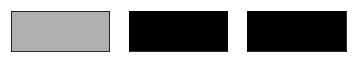

In [67]:
f, ax = plt.subplots(1, 3, subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(lesion[46:,:,87], cmap=plt.cm.gray)
ax[1].imshow(tmax[46:,:,87], cmap=plt.cm.gray)
ax[2].imshow(adc[46:,:,87], cmap=plt.cm.gray)
plt.show()

In [69]:
np.sum(lesion[46:,:,87])

-2.4102333586386854e-43